In [1]:
using StaticArrays
using ACME

arcchannel(;R0=1e-3, L0=1e-3) =
  ACME.Element(mv=[1;1;0;0;0], mi=[0;0;1;0;0], mx=[0 -1;0 0;0 0;1 0;0 1], mxd=[-1 0;0 0;0 0;0 0;0 0],
        mq=[0 0 0 0;-1 0 0 0;0 -1 0 0; 0 0 -1 0; 0 0 0 -1], ports=[:1 => :2],
        nonlinear_eq = @inline function(q)
            v, i, Φ, u = q
            Ri = R0 * i
            Li = L0 * i + i^3 #L0 * tanh(5i)
            j = @SVector [(Ri - u), (Li - Φ)]
            J = @SMatrix [(.0) (R0) (.0) (-1);
                          (.0) (L0 + 3i^2) (-1) (.0)] # (5L0 / cosh(5i)^2)
            return (j, J)
        end)

cir = @circuit begin
    i = currentsource()
    v = voltageprobe()
    ⚡ = arcchannel()
end

connect!(cir, (:i, +), (:v, +), (:⚡, 1))
connect!(cir, (:i, -), (:v, -), (:⚡, 2), :gnd)

In [2]:
model = DiscreteModel(cir, 1/1000)

t = 0:0.001:1.0
u = similar(t)
y = similar(u)

for i=1:length(t)
    u[i] = sin(2π * 1 * t[i])
    y[i,:,:].= run!(model, u[i,:,:])
end

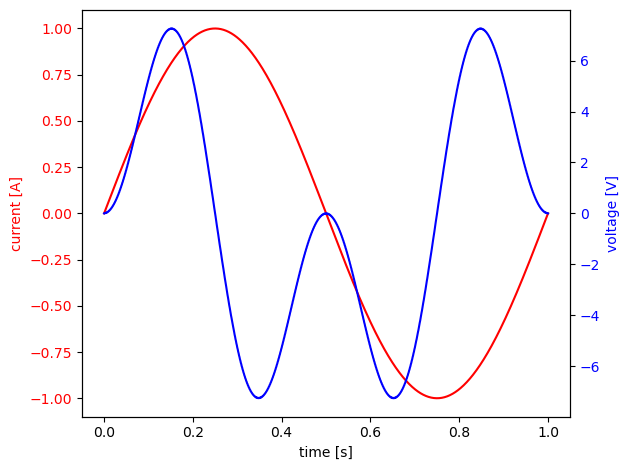

In [3]:
using PyPlot
fig, yleft = subplots()
yright = yleft.twinx()

yleft.set_ylabel("current [A]", color="red")
yleft.tick_params(axis="y", labelcolor="red")
yleft.plot(t, u, color="red")

yright.set_ylabel("voltage [V]", color="blue")
yright.tick_params(axis="y", labelcolor="blue")
yright.plot(t, y, color="blue")

yleft.set_xlabel("time [s]")
fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [4]:
pressure = 750.0
distance = 0.001
tbreak = NaN

gasdensity(p) = 1.2p / 760 # at 25 degrees C.
electricfield(V, d) = V / d
resistance(r, d, ∫i²) = 876.0d * r^(2/5) / ∫i²^(3/5) # Vlastos
inductance(r, d) = 2.0d * (log(2d / r) - .75) * 1e-9 # Wire Inductance

Braginskii(ρ, i, t) = 9.3e-4 * i^(1/3) * t^(1/2) * ρ^(1/6)
THMartin(E, ρ) = 98700 * (E / ρ + 1e-15) ^ (-3.44) / ρ
Bruce(p, d) = (24.55 * (d / 760)^(1.0) * (1e2p)^(1.0) +
                6.66 * (d / 760)^(0.5) * (1e2p)^(0.5)) * 1000

overvoltage(tbreak, Vbreak, t, V) = (V > Vbreak) ? (isnan(tbreak) ? t : tbreak) : (NaN)
channel(tbreak, tdelay, t, ich, imin) = (time > tbreak + tdelay) ? (t - tbreak - tdelay) : (0.0)

channel (generic function with 1 method)

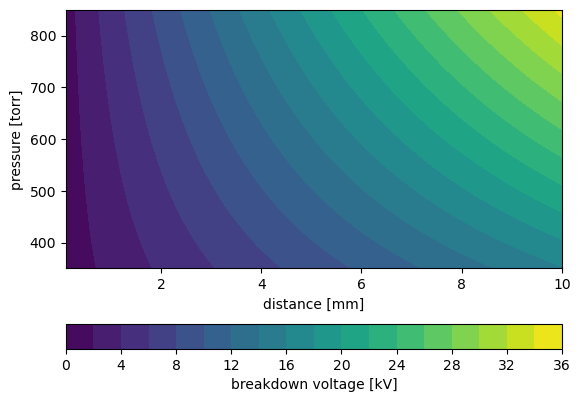

In [5]:
Vbreak = [Bruce(p, d) for p in 350:850, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 350:850, 1e-3Vbreak; levels=20)
xlabel("distance [mm]")
ylabel("pressure [torr]")
colorbar(location="bottom").set_label("breakdown voltage [kV]");

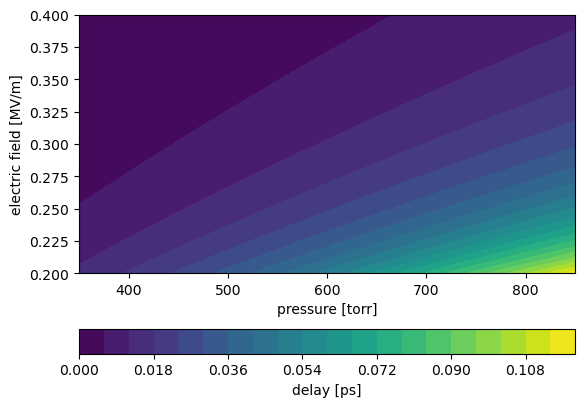

In [6]:
tdelay = [THMartin(E, gasdensity(p)) for E in 0.2e6:0.01e6:0.4e6, p in 350:850]
contourf(350:850, 0.2:0.01:0.4, 1e12tdelay; levels=20)
xlabel("pressure [torr]")
ylabel("electric field [MV/m]")
colorbar(location="bottom").set_label("delay [ps]");

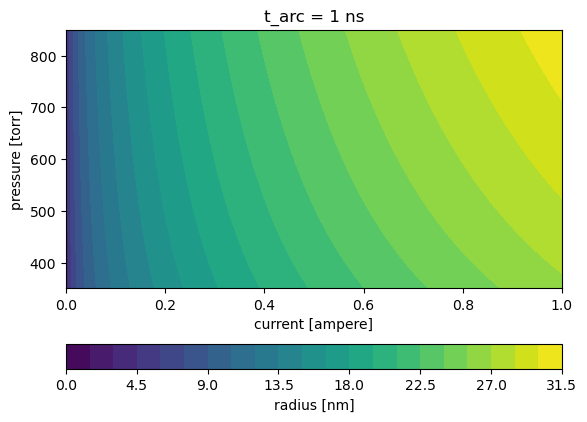

In [7]:
radius = [Braginskii(gasdensity(p), i, 1e-9) for p in 350:850, i in 0.0:2e-3:1.0]
contourf(0.0:2e-3:1.0, 350:850, 1e9radius; levels=20)
xlabel("current [ampere]")
ylabel("pressure [torr]")
title("t_arc = 1 ns")
colorbar(location="bottom").set_label("radius [nm]");

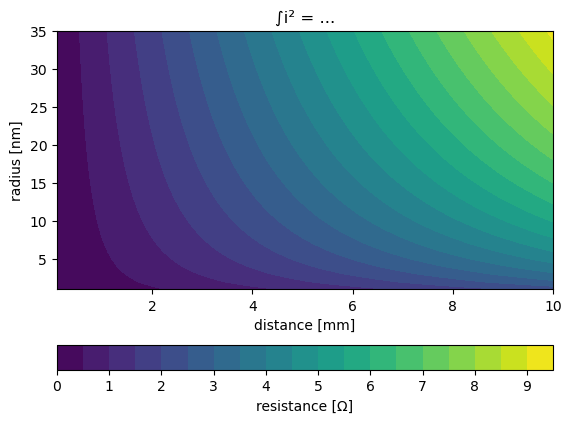

In [8]:
Rch = [resistance(r, d, 10e-6) for r in 1e-9:1e-9:35e-9, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 1:35, Rch; levels=20)
xlabel("distance [mm]")
ylabel("radius [nm]")
title("∫i² = ...")
colorbar(location="bottom").set_label("resistance [Ω]");

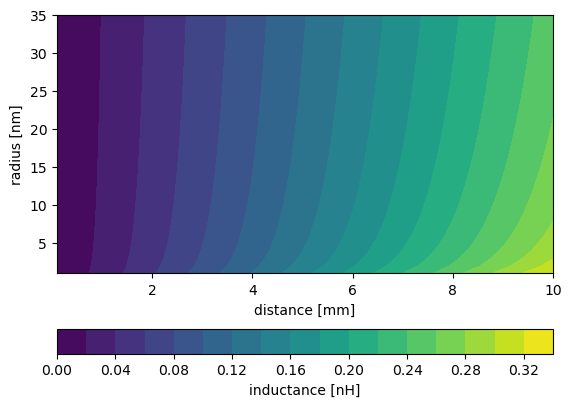

In [9]:
Lch = [inductance(r, d) for r in 1e-9:1e-9:35e-9, d in 0.0001:0.0001:0.01]
contourf(0.1:0.1:10, 1:35, 1e9Lch; levels=20)
xlabel("distance [mm]")
ylabel("radius [nm]")
colorbar(location="bottom").set_label("inductance [nH]");